# What is Pneumonia?


Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.


 Chest X-ray imaging is commonly used to diagnose pneumonia, as it can reveal important symptoms, such as increased lung opacity and consolidation. However, it can be difficult to interpret a chest X-ray (CXR) because pneumonia symptoms can be subtle and overlap with other lung diseases. Rapid and accurate diagnosis of pneumonia is essential for expediting treatment and improving patient outcomes. 


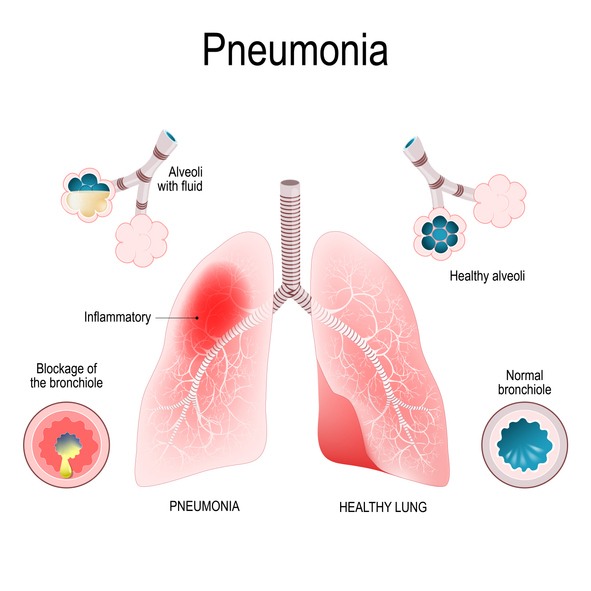

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
count = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        count+=1
        if count > 10:
            break
    if count > 10:
        break

# Any results you write to the current directory are saved as output.

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# Importing the necessary libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

Using TensorFlow backend.


# Description of the Pneumonia Dataset
**The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.**

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [4]:
train = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_training_data('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Data Visualization & Preprocessing

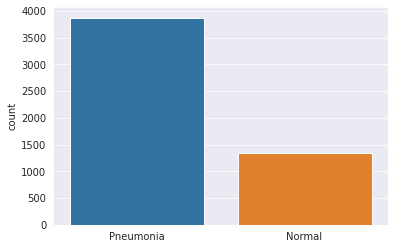

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)        

**The data seems imbalanced . To increase the no. of training examples, we will use data augmentation**

**Previewing the images of both the classes**

In [46]:
## are all the images of same size ?
for img,label in train:
    if img.shape != (150, 150):
        print(f'Image is not same {img.shape}')

Bad: Solid White (Mean: 221.48)
Bad: Solid White (Mean: 201.74)


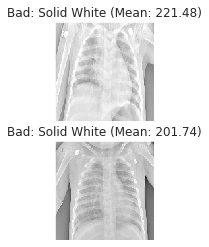

In [61]:
import cv2
import numpy as np

def check_image_quality(img):
    # 1. Load the image in grayscale
    #img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        return "Error: Could not load image"

    # Convert to float for accurate calculation
    data = img.astype(np.float64)
    
    # 2. Calculate Mean and Standard Deviation
    mean_intensity = np.mean(data)
    std_dev = np.std(data)

    # Define thresholds (adjust these based on your specific image set)
    DARK_THRESHOLD = 50.0    # Max mean for solid dark
    WHITE_THRESHOLD = 200.0 # Min mean for solid white
    CONTRAST_THRESHOLD = 15.0 # Min std dev for meaningful contrast

    results = []

    # Check 1: Solid Dark
    if mean_intensity < DARK_THRESHOLD:
        results.append(f"Bad: Solid Dark (Mean: {mean_intensity:.2f})")

    # Check 2: Solid White
    if mean_intensity > WHITE_THRESHOLD:
        results.append(f"Bad: Solid White (Mean: {mean_intensity:.2f})")

    # Check 3: Low Contrast / No Information
    if std_dev < CONTRAST_THRESHOLD:
        results.append(f"Bad: Low Contrast / No Info (Std Dev: {std_dev:.2f})")

    if not results:
        #return f"Good Image (Mean: {mean_intensity:.2f}, Std Dev: {std_dev:.2f})"
        return None
    else:
        return "\n".join(results),img

bad_images = []
for img,label in train:
    res = check_image_quality(img)
    if res is not None:
        bad_images.append(res)
        print(res[0])
        
#fig, axes = plt.subplot(len(bad_images),1)
n = len(bad_images)
for i in range(len(bad_images)):
    plt.subplot(n,1,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(bad_images[i][1], cmap="gray", interpolation='none')
    plt.title(bad_images[i][0])

    

### Looks like there are some over exposed xrays. 

Text(0.5, 1.0, 'NORMAL')

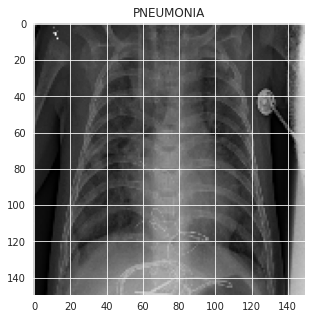

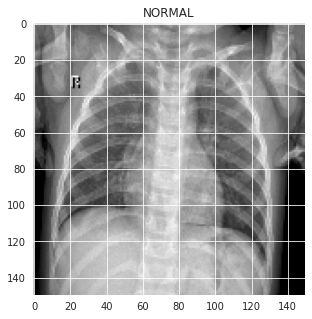

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

**We perform a grayscale normalization to reduce the effect of illumination's differences.Moreover the CNN converges faster on [0..1] data than on [0..255].**

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

## Why This Transformation is Necessary 
Deep learning frameworks like TensorFlow and Keras expect image data to be in a 4D tensor format:

(batch_size, height, width, channels)

In [9]:
# resize data for deep learning 
print(x_train.shape)
x_train = x_train.reshape(-1, img_size, img_size, 1)
print(x_train.shape)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

(5216, 150, 150)
(5216, 150, 150, 1)


# Data Augmentation
**In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations.
Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.
By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.**

In [10]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

For the data augmentation, i choosed to :
1. Randomly rotate some training images by 30 degrees 
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width 
4. Randomly shift images vertically by 10% of the height 
5. Randomly flip images horizontally.
Once our model is ready, we fit the training dataset.

### Hyperparameter Tuning

We will build a smaller model to test for training rate and Optimizer

In [16]:
toy_model = Sequential()
toy_model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
toy_model.add(BatchNormalization())
toy_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
toy_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
toy_model.add(Dropout(0.1))
toy_model.add(BatchNormalization())
toy_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
toy_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
toy_model.add(Dense(units = 128 , activation = 'relu'))
toy_model.add(Dropout(0.2))
toy_model.add(Flatten())
toy_model.add(Dense(units = 1 , activation = 'sigmoid'))
toy_model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
toy_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_5 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 38, 38, 64)       

In [17]:
from tensorflow.keras import callbacks

# Define the EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=2,          # Stop if no improvement for 2 epochs
    restore_best_weights=True # Restore weights from the best epoch
)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = toy_model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])


Epoch 1/12
163/163 [==============================] - 14s 86ms/step - loss: 1.6193 - accuracy: 0.7650 - val_loss: 2.6825 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 9s 56ms/step - loss: 0.3081 - accuracy: 0.8836 - val_loss: 3.9331 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 9s 56ms/step - loss: 0.2718 - accuracy: 0.9001 - val_loss: 1.3160 - val_accuracy: 0.5625
Epoch 4/12
163/163 [==============================] - 9s 56ms/step - loss: 0.2542 - accuracy: 0.9105 - val_loss: 1.7970 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 9s 56ms/step - loss: 0.2111 - accuracy: 0.9195 - val_loss: 4.8711 - val_accuracy: 0.5000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/12
163/163 [==============================] - 9s 57ms/step - loss: 0.1567 - accuracy: 0.9450 - val_loss: 1.8337 - val_accuracy: 0.5000
Epoch 7/12
163/163 [==============================] - 9s 56m

#### Observations. 
We see that training loos and accuracy seems to drop consistently but validaiton loos and accuracy jumps around. We can try Adam optimizer to see if we get better results.

Current val_loss: 1.0045



In [18]:
toy_model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
history = toy_model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])


Epoch 1/12
163/163 [==============================] - 10s 61ms/step - loss: 0.1870 - accuracy: 0.9304 - val_loss: 0.8122 - val_accuracy: 0.6250
Epoch 2/12
163/163 [==============================] - 9s 58ms/step - loss: 0.1664 - accuracy: 0.9381 - val_loss: 0.7018 - val_accuracy: 0.7500
Epoch 3/12
163/163 [==============================] - 9s 58ms/step - loss: 0.1745 - accuracy: 0.9346 - val_loss: 0.9860 - val_accuracy: 0.6875
Epoch 4/12
163/163 [==============================] - 9s 57ms/step - loss: 0.1620 - accuracy: 0.9394 - val_loss: 1.1714 - val_accuracy: 0.5625

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/12
163/163 [==============================] - 9s 57ms/step - loss: 0.1267 - accuracy: 0.9511 - val_loss: 1.0492 - val_accuracy: 0.6250
Epoch 6/12
163/163 [==============================] - 9s 58ms/step - loss: 0.1205 - accuracy: 0.9551 - val_loss: 1.1479 - val_accuracy: 0.5000

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.

#### Adam seems to be performing better. Lets try smaller batch sizes

In [19]:
toy_model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
history = toy_model.fit(datagen.flow(x_train,y_train, batch_size = 16) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])


Epoch 1/12
326/326 [==============================] - 11s 33ms/step - loss: 0.1918 - accuracy: 0.9293 - val_loss: 0.9297 - val_accuracy: 0.5625
Epoch 2/12
326/326 [==============================] - 10s 30ms/step - loss: 0.1755 - accuracy: 0.9360 - val_loss: 0.5034 - val_accuracy: 0.7500
Epoch 3/12
326/326 [==============================] - 10s 31ms/step - loss: 0.1670 - accuracy: 0.9369 - val_loss: 0.9176 - val_accuracy: 0.6250
Epoch 4/12
326/326 [==============================] - 10s 31ms/step - loss: 0.1587 - accuracy: 0.9394 - val_loss: 1.5198 - val_accuracy: 0.5625

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/12
326/326 [==============================] - 10s 30ms/step - loss: 0.1341 - accuracy: 0.9486 - val_loss: 1.4140 - val_accuracy: 0.5625
Epoch 6/12
326/326 [==============================] - 10s 32ms/step - loss: 0.1186 - accuracy: 0.9542 - val_loss: 1.2459 - val_accuracy: 0.5625

Epoch 00006: ReduceLROnPlateau reducing learning rate 

#### That did not help. The val_loss increased to val_loss: 0.9799. We'll stay with batch size = 32
Lets try adding Convl layers with bigger filters

In [20]:
toy_model = Sequential()
toy_model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
toy_model.add(BatchNormalization())
toy_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
toy_model.add(Conv2D(64 , (5,5) , strides = 1 , padding = 'same' , activation = 'relu'))
toy_model.add(Dropout(0.1))
toy_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
toy_model.add(Dropout(0.1))
toy_model.add(BatchNormalization())
toy_model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
toy_model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
toy_model.add(Dense(units = 128 , activation = 'relu'))
toy_model.add(Dropout(0.2))
toy_model.add(Flatten())
toy_model.add(Dense(units = 1 , activation = 'sigmoid'))
toy_model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
history = toy_model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])


Epoch 1/12
163/163 [==============================] - 10s 64ms/step - loss: 0.5397 - accuracy: 0.8484 - val_loss: 5.0597 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 10s 59ms/step - loss: 0.2085 - accuracy: 0.9170 - val_loss: 6.6488 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 10s 60ms/step - loss: 0.1899 - accuracy: 0.9268 - val_loss: 0.5208 - val_accuracy: 0.7500
Epoch 4/12
163/163 [==============================] - 10s 60ms/step - loss: 0.1912 - accuracy: 0.9264 - val_loss: 3.7333 - val_accuracy: 0.5000
Epoch 5/12
163/163 [==============================] - 10s 60ms/step - loss: 0.1767 - accuracy: 0.9314 - val_loss: 22.2447 - val_accuracy: 0.5000

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/12
163/163 [==============================] - 10s 60ms/step - loss: 0.1368 - accuracy: 0.9509 - val_loss: 2.0234 - val_accuracy: 0.5000
Epoch 7/12
163/163 [==============================] - 

### THis backfired. We will stick with 3x3 filters.


# Training the Final Model

In [21]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout_10 (Dropout)         (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 38, 38, 64)       

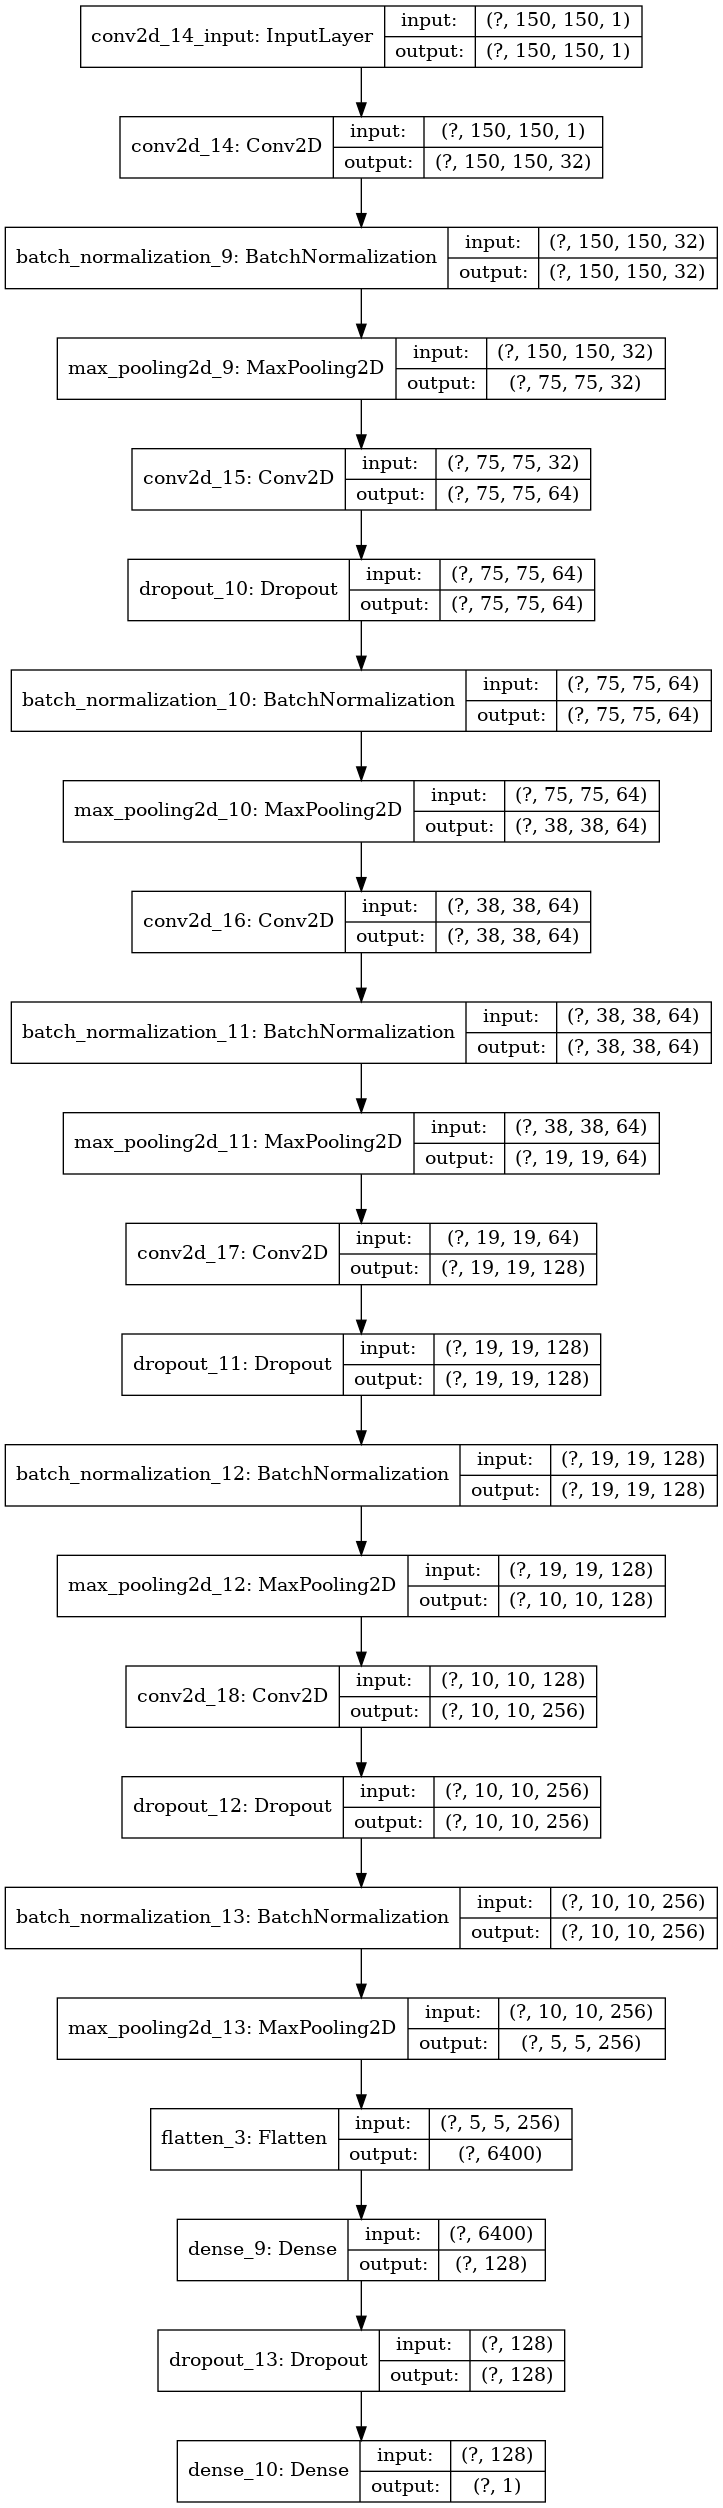

In [22]:
from tensorflow.keras.utils import plot_model

plot_model(
    model,
    to_file='model_architecture.png',  # File name to save the plot
    show_shapes=True,                # Display input/output shapes of layers
    show_layer_names=True,           # Display layer names
    expand_nested=True,              # Expand nested models (if any)
    dpi=96                           # Dots per inch for the image
)

In [26]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/20
163/163 [==============================] - 10s 60ms/step - loss: 0.0897 - accuracy: 0.9699 - val_loss: 1.0914 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 10s 59ms/step - loss: 0.0943 - accuracy: 0.9695 - val_loss: 1.2366 - val_accuracy: 0.6250
Epoch 3/20
163/163 [==============================] - 10s 59ms/step - loss: 0.0892 - accuracy: 0.9691 - val_loss: 1.2837 - val_accuracy: 0.5000
Epoch 4/20
163/163 [==============================] - 10s 59ms/step - loss: 0.0871 - accuracy: 0.9680 - val_loss: 0.8766 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 10s 59ms/step - loss: 0.0908 - accuracy: 0.9670 - val_loss: 1.2075 - val_accuracy: 0.5625
Epoch 6/20
163/163 [==============================] - 9s 58ms/step - loss: 0.0858 - accuracy: 0.9703 - val_loss: 1.0291 - val_accuracy: 0.5625
Epoch 7/20
163/163 [==============================] - 10s 58ms/step - loss: 0.0854 - accuracy: 0.9678 - val_loss: 1.0472 - val_accuracy: 

In [27]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

624/624 [==============================] - 0s 482us/step
Loss of the model is -  0.23123100266242638
624/624 [==============================] - 0s 464us/step
Accuracy of the model is -  91.50640964508057 %


# Analysis after Model Training

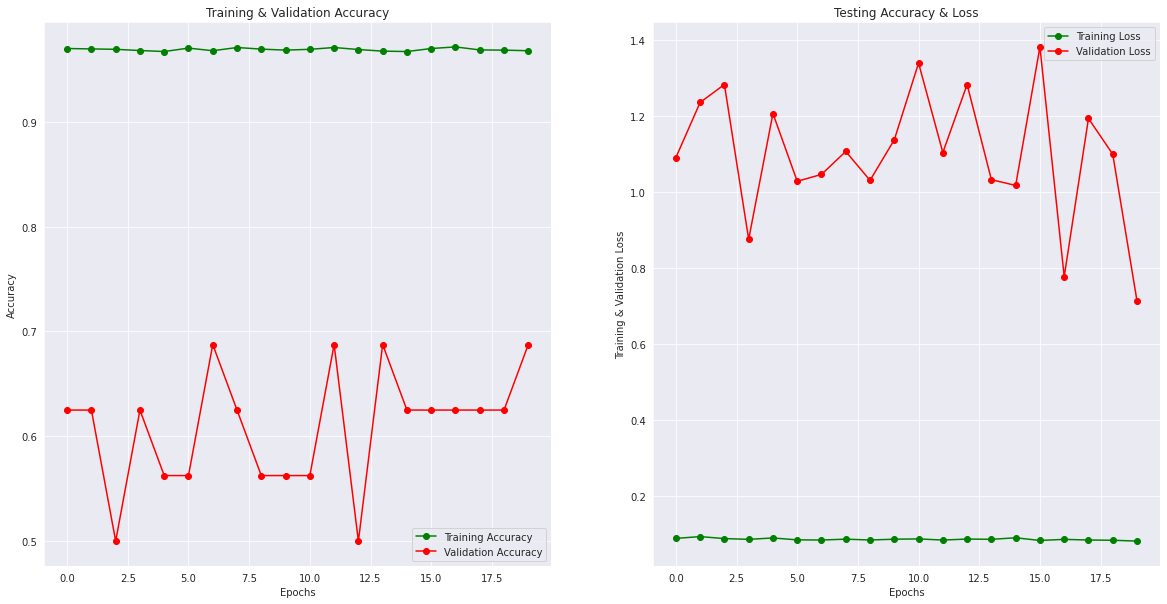

In [29]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [30]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0], dtype=int32)

In [31]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.94      0.93       390
   Normal (Class 1)       0.90      0.88      0.89       234

           accuracy                           0.92       624
          macro avg       0.91      0.91      0.91       624
       weighted avg       0.91      0.92      0.91       624



In [32]:
cm = confusion_matrix(y_test,predictions)
cm

array([[366,  24],
       [ 29, 205]])

In [33]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

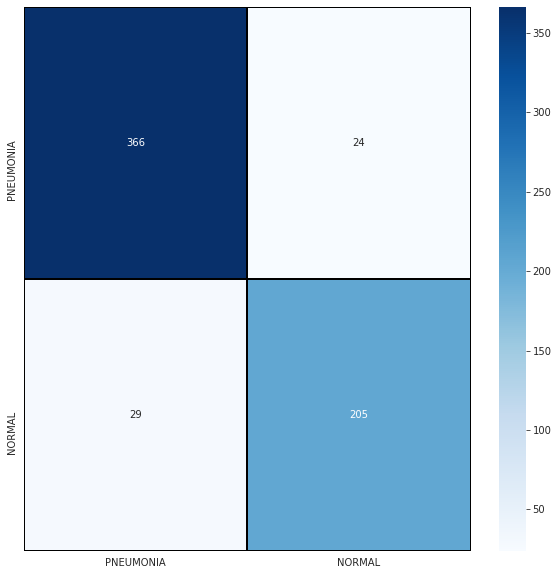

In [34]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [35]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

**Some of the Correctly Predicted Classes**

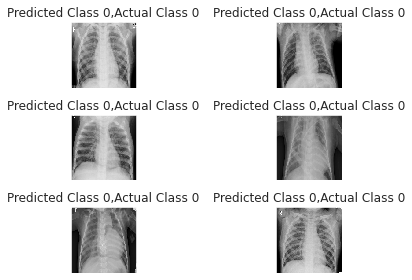

In [36]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

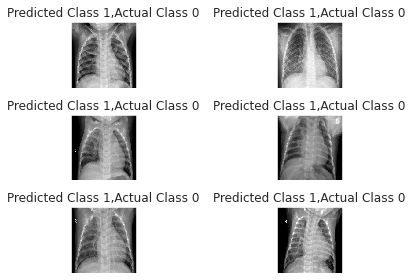

In [37]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

## Summary and Conclusion
With the final model we achieve pretty high accuracy on the test dataset of 91% and F1 score of 93 %. These are pretty good results and I am sure with larger dataset these numbers could even go up. The medical industry is already starting to use these techniques in the field now. 
Other observations include the fact that that validation accuracy jumps around a lot with epochs as and some investigation is needed in to figuring out as to what the reason is. 
